<a href="https://colab.research.google.com/github/LukaszSzarecki/music-source-separation/blob/develop/primitive_algorithms_pl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[PL]** W ramach tego notatnika, można przetestować proste algorytmy separacji dźwiękowej zbudowane w oparciu o analizę czasowo-częstotliwościową. Poniższe algorytmy to:
1. Algorytm REPET - Technika ekstrakcji powtarzającego się wzorca
2. Algorytm 2DFT - Technika oparta o dwuwymiarową transformacje Fouriera
3. Algorytm HPSS - Separacja harmoniczna/perkusyjna


In [ ]:
!pip install nussl
!pip install scaper
import nussl
import matplotlib.pyplot as plt
import numpy as np

# 1. REPET - Technika ekstrakcji powtarzającego się wzoru

Kroki algorytmu REPET



1.   Znalezienie powtarzającego się okresu
2.   Podzielenie spektogramu na segmenty, każdy o długości powtarzającego się okresu
3.   Nałożenie na siebie wyodrębnionych segmentów
4.   Obliczenie mediany nałożonych segmentów i stworzenie maski

Zastosowanie algorytmu:
1.   Służy rozdzieleniu powtarzającego się tła muzycznego od nieregularnych dźwięków będących w pierwszym planie 





## Określenie powtarzającego się okresu



In [2]:
# r_audio_path = nussl.efz_utils.download_audio_file('historyrepeating_7olLrex.wav')
r_audio_path = nussl.efz_utils.download_audio_file('mix4.wav')
repet_signal = nussl.AudioSignal(r_audio_path)
repet_signal.embed_audio()
print(repet_signal)

Saving file at /root/.nussl/audio/mix4.wav
mix4.wav...100%


AudioSignal (unlabeled): 10.000 sec @ /root/.nussl/audio/mix4.wav, 44100 Hz, 1 ch.


Pliki audio ze zbioru MUSDB18 do testowania algorytmów separacji 

In [ ]:
nussl.efz_utils.print_available_audio_files()

File Name                                Duration (sec)  Size       Description                                       
K0140.wav                                5.00390022675737 431.0KiB   Acoustic piano playing middle C.                  
K0149.wav                                4.992290249433107 430.0KiB   Acoustic piano playing A above middle C (A440).   
dev1_female3_inst_mix.wav                           10.0 1.7MiB     Instantaneous mixture of three female speakers talking in a stereo field.
dev1_female3_synthconv_130ms_5cm_mix.wav            10.0 1.7MiB     Three female speakers talking in a stereo field, with 130ms of inter-channel delay.
mix_3s.wav                                           3.0 258.4KiB   Drums and flute.                                  
drums.wav                                           10.0 861.4KiB   Drums playing a simple beat.                      
flute.wav                                11.000045351473922 947.5KiB   Flute playing a melody repeated twice

Znalezienie powtarzającego się okresu

In [3]:
repet_exact_period = nussl.separation.primitive.Repet(
    repet_signal, period=3.5)  # stały okres
repet_period_guess = nussl.separation.primitive.Repet(
    repet_signal, min_period=3.4, max_period=3.6)  # okres w przedziale min, max

repet = nussl.separation.primitive.Repet(repet_signal) #okres ustawiany automatycznie
_ = repet.run()

Wykreślenie widma bitu (ang. beat spectrum)

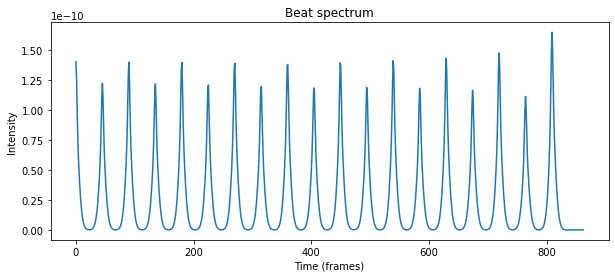

In [4]:
# Właściwości REPET
plt.figure(figsize=(10, 4))
plt.plot(repet.beat_spectrum)
plt.xlabel('Time (frames)')
plt.ylabel('Intensity')
plt.title('Beat spectrum')
plt.show()
# Obserwujemy regularnie powtarzający się okres.

## Uruchomienie REPET - automatycznie

In [5]:
# Uruchomienie algorytmu
masks = repet.run() # run zwraca maski nakładane na sygnał
print(masks)

estimates = repet() # tworzy sygnały audio
print(repet.repeating_period)

[<nussl.core.masks.soft_mask.SoftMask object at 0x7fe699252050>, <nussl.core.masks.soft_mask.SoftMask object at 0x7fe699277910>]
90


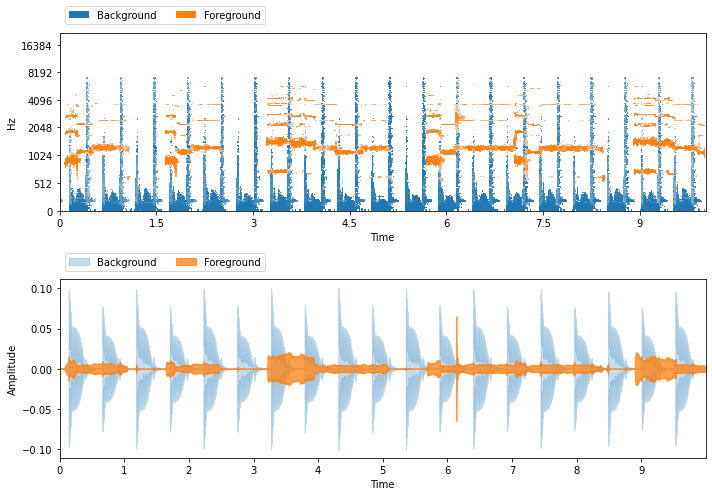


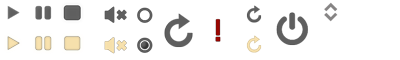
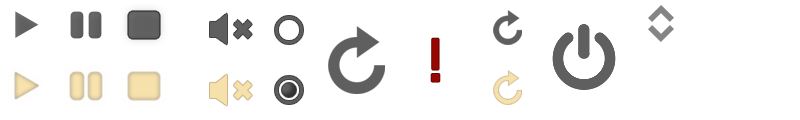
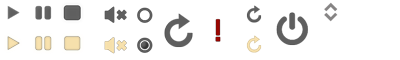

In [7]:
_estimates = {
    'Background': estimates[0],
    'Foreground': estimates[1]
} 

plt.figure(figsize=(10, 7))
plt.subplot(211)
nussl.utils.visualize_sources_as_masks(
    _estimates, db_cutoff=-60, y_axis='mel')
plt.subplot(212)
nussl.utils.visualize_sources_as_waveform(
    _estimates, show_legend=True)
plt.tight_layout()
plt.show()

nussl.play_utils.multitrack(_estimates)

## Uruchomienie REPET - manualnie

In [8]:
bg_mask, fg_mask = repet.run()
# repet zwraca maski

Automatyczne nałożenie masek metodą klasy AudioSignal w nussl ``` apply_mask() ```



In [ ]:
# Skorzystanie z metody nałożenia masek

bg_sound = repet_signal.apply_mask(bg_mask)
bg_sound.istft()
bg_sound = bg_sound.apply_gain(10)
bg_sound.embed_audio()
print(bg_sound)

fg_sound = repet_signal.apply_mask(fg_mask)
fg_sound.istft()
fg_sound = fg_sound.apply_gain(10)
fg_sound.embed_audio()
print(fg_sound)

AudioSignal (unlabeled): 10.000 sec @ /root/.nussl/audio/mix4.wav, 44100 Hz, 1 ch.


AudioSignal (unlabeled): 10.000 sec @ /root/.nussl/audio/mix4.wav, 44100 Hz, 1 ch.


Zastowsowanie masek bez uwzględnienia fazy

In [9]:
# Pobranie macierzy masek w postacji numpy arrays
bg_mask_arr = bg_mask.mask
fg_mask_arr = fg_mask.mask

# Nałożenie masek na widmo amplitudowe sygnału 
repet_signal.stft()
repet_signal_mag_spec = repet_signal.magnitude_spectrogram_data
bg_no_phase_spec = repet_signal_mag_spec * bg_mask_arr # mnożenie macierzy element po elemencie
fg_no_phase_spec = repet_signal_mag_spec * fg_mask_arr 

# Utworzenie nowych sygnałów dla tła i pierwszego planu typu AudioSignal
bg_no_phase = repet_signal.make_copy_with_stft_data(bg_no_phase_spec)
_ = bg_no_phase.istft()
fg_no_phase = repet_signal.make_copy_with_stft_data(fg_no_phase_spec)
_ = fg_no_phase.istft()

print('Tło bez uwzględnienia fazy')
bg_no_phase = bg_no_phase.apply_gain(20)
_ = bg_no_phase.embed_audio()

print('Pierwszy plan bez uwzględnienia fazy')
fg_no_phase = fg_no_phase.apply_gain(20)
_ = fg_no_phase.embed_audio()

/usr/local/lib/python3.7/dist-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


TŁo bez uwzględnienia fazy


Pierwszy plan bez uwzględnienia fazy


Zastowsowanie masek z uwzględnieniem fazy

In [10]:
bg_mask_arr = bg_mask.mask
fg_mask_arr = fg_mask.mask

def apply_mask_with_noisy_phase(repet_signal_stft, mask):
    repet_signal_magnitude, repet_signal_phase = np.abs(repet_signal_stft), np.angle(repet_signal_stft)
    src_magnitude = repet_signal_magnitude * mask
    src_stft = src_magnitude * np.exp(1j * repet_signal_phase)
    return src_stft

bg_stft = apply_mask_with_noisy_phase(repet_signal.stft_data, bg_mask_arr)
fg_stft = apply_mask_with_noisy_phase(repet_signal.stft_data, fg_mask_arr)


# Stworz nowe sygnaly dla tła i pierwszego planu z uwzględnieniem fazy typu AudioSignal
bg_phase = repet_signal.make_copy_with_stft_data(bg_stft)
_ = bg_phase.istft()
fg_phase = repet_signal.make_copy_with_stft_data(fg_stft)
_ = fg_phase.istft()


In [11]:
print('Tło z uwzględnieniem fazy')
_ = bg_phase.embed_audio()

print('Pierwszy plan z uwzględnieniem fazy')
_ = fg_phase.embed_audio()

Tło z uwzględnieniem fazy


Pierwszy plan z uwzględnieniem fazy


# 2DFT

In [12]:
ft2d_audio_path = nussl.efz_utils.download_audio_file('historyrepeating_7olLrex.wav')
ft2d_signal = nussl.AudioSignal(ft2d_audio_path)
ft2d_signal.embed_audio()
print(ft2d_signal)

Saving file at /root/.nussl/audio/historyrepeating_7olLrex.wav
historyrepeating_7olLrex.wav...100%


AudioSignal (unlabeled): 12.761 sec @ /root/.nussl/audio/historyrepeating_7olLrex.wav, 44100 Hz, 1 ch.


In [13]:
ft2d_signal.stft()
ft2d_signal.to_mono()

ft2d_separation = nussl.separation.primitive.FT2D(ft2d_signal) 
bg_mask, fg_mask = ft2d_separation.run()

In [14]:
bg_sound = ft2d_signal.apply_mask(bg_mask)
bg_sound.istft()
bg_sound.embed_audio()
print(bg_sound)

fg_sound = ft2d_signal.apply_mask(fg_mask)
fg_sound.istft()
fg_sound.embed_audio()
print(fg_sound)

AudioSignal (unlabeled): 12.761 sec @ /root/.nussl/audio/historyrepeating_7olLrex.wav, 44100 Hz, 1 ch.


AudioSignal (unlabeled): 12.761 sec @ /root/.nussl/audio/historyrepeating_7olLrex.wav, 44100 Hz, 1 ch.


[Text(0.5, 1.0, 'Spektrogram amplitudowy w skali melowej tła muzycznego')]

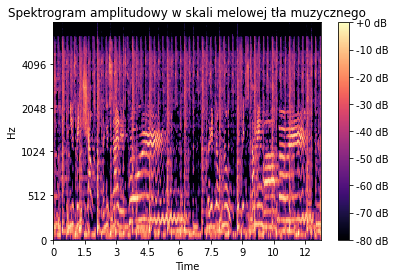

In [16]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

# y, sr = librosa.load(librosa.ex('trumpet'))
y = fg_sound.audio_data.flatten()
sr = 44100
librosa.feature.melspectrogram(y=y, sr=sr)

D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Spektrogram amplitudowy w skali melowej tła muzycznego')

[Text(0.5, 1.0, 'Spektrogram amplitudowy w skali melowej pierwszego planu')]

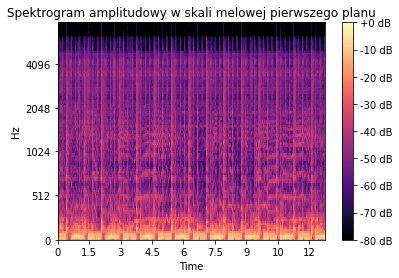

In [17]:
y = bg_sound.audio_data.flatten()
sr = 44100
librosa.feature.melspectrogram(y=y, sr=sr)

D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Spektrogram amplitudowy w skali melowej pierwszego planu')

[Text(0.5, 1.0, 'Spetkrogram amplitudowy w skali melowej miksu')]

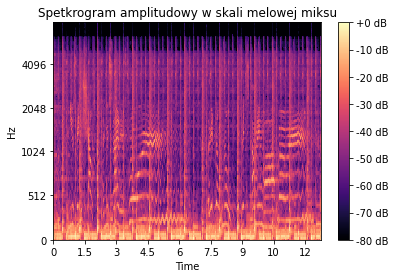

In [18]:
y = ft2d_signal.audio_data.flatten()
sr = 44100
librosa.feature.melspectrogram(y=y, sr=sr)

D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Spetkrogram amplitudowy w skali melowej miksu')

## Kod pomocniczy - nieużywany

[Text(0.5, 1.0, 'Mel-frequency mix spectrogram')]

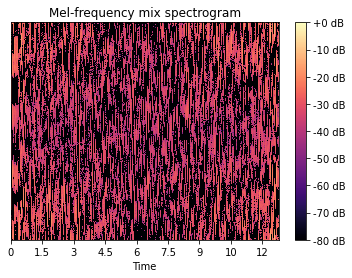

In [ ]:
y = bg_sound.audio_data.flatten()

D = np.fft.fft2(np.abs(librosa.stft(y)))
S = librosa.feature.melspectrogram(S=D, sr=sr)


S_dB = librosa.power_to_db(np.real(D), ref=np.max)
fig, ax = plt.subplots()

img = librosa.display.specshow(S_dB, x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency mix spectrogram')

[Text(0.5, 1.0, 'Mel-frequency mix spectrogram')]

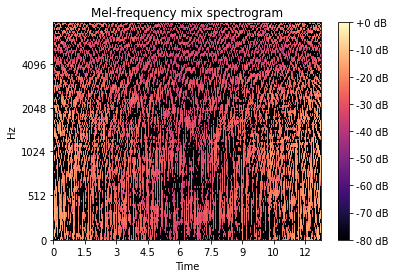

In [ ]:
y = fg_sound.audio_data.flatten()

D = np.fft.fft2(np.abs(librosa.stft(y)))
S = librosa.feature.melspectrogram(S=D, sr=sr)


S_dB = librosa.power_to_db(np.real(S), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency mix spectrogram')

# HPSS - Separacja harmoniczna/perkusyjna

In [19]:
hp_audio_path = nussl.efz_utils.download_audio_file('historyrepeating_7olLrex.wav')
hp_signal = nussl.AudioSignal(hp_audio_path)
hp_signal.embed_audio()
print(hp_signal)

Matching file found at /root/.nussl/audio/historyrepeating_7olLrex.wav, skipping download.


AudioSignal (unlabeled): 12.761 sec @ /root/.nussl/audio/historyrepeating_7olLrex.wav, 44100 Hz, 1 ch.


In [20]:
hp_signal.stft()
hp_signal.to_mono()

hp_separation = nussl.separation.primitive.HPSS(hp_signal) #okres ustawiany automatycznie
harmonic_mask, percussive_mask = hp_separation.run()


In [22]:
hp_signal.stft_data[0]

array([[-0.01416397+0.j],
       [-0.03460977+0.j],
       [ 0.00777505+0.j],
       ...,
       [ 0.04186499+0.j],
       [ 0.02795779+0.j],
       [ 0.02677824+0.j]], dtype=complex64)

In [23]:
hp_sound = hp_signal.apply_mask(harmonic_mask)
hp_sound.istft()
hp_sound.embed_audio()
print(hp_sound)

pm_sound = hp_signal.apply_mask(percussive_mask)
pm_sound.istft()
pm_sound.embed_audio()
print(pm_sound)

AudioSignal (unlabeled): 12.761 sec @ /root/.nussl/audio/historyrepeating_7olLrex.wav, 44100 Hz, 1 ch.


AudioSignal (unlabeled): 12.761 sec @ /root/.nussl/audio/historyrepeating_7olLrex.wav, 44100 Hz, 1 ch.


## Kod pomocniczy - nieużywany




[Text(0.5, 1.0, 'Spektrogram amplitudowy miksu')]

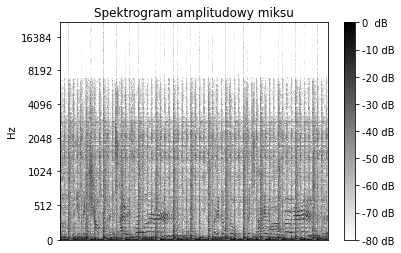

In [32]:
import librosa
sr = 44100
fig, ax = plt.subplots()

C_db = librosa.amplitude_to_db(np.abs(hp_signal.stft_data[..., 0]), ref=np.max)


img = librosa.display.specshow(C_db,cmap='gray_r', sr=sr, ax=ax, y_axis='mel')
fig.colorbar(img, ax=ax, format='%-2.0f dB')
ax.set(title='Spektrogram amplitudowy miksu')



In [25]:
C_db

array([[-27.622673, -19.8624  , -32.832306, ..., -18.209354, -21.71632 ,
        -22.090733],
       [-28.654263, -30.905235, -15.488399, ..., -28.775478, -18.362602,
        -21.0737  ],
       [-29.727837, -21.33995 , -12.704862, ...,  -8.23393 , -13.098691,
        -19.480011],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

[Text(0.5, 1.0, 'Spektrogram maski harmonicznej')]

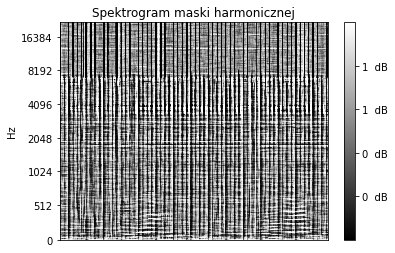

In [33]:

# maska = masks[1].mask[...,0]
maska = harmonic_mask.mask[...,0]


fig, ax = plt.subplots()
# C_db = librosa.amplitude_to_db(np.abs(maska), ref=np.max)

img = librosa.display.specshow(maska,cmap='gray', sr=sr, ax=ax, y_axis='mel')
fig.colorbar(img, ax=ax, format='%-2.0f dB')
ax.set(title='Spektrogram maski harmonicznej')



In [28]:
maska = harmonic_mask.mask[...,0]
np.set_printoptions(suppress=True)
print(maska)

[[0.6843915  0.26937914 0.08102009 ... 0.02708924 0.03885476 0.20022337]
 [0.71648663 0.30054528 0.10046469 ... 0.08069508 0.11303781 0.48869798]
 [0.96106017 0.790652   0.57013947 ... 0.4222792  0.5367947  0.874685  ]
 ...
 [0.01387581 0.00635457 0.00311645 ... 0.06992254 0.17591348 0.26286492]
 [0.01878635 0.00862669 0.0042357  ... 0.0585038  0.14997691 0.22816594]
 [0.05873179 0.02734248 0.01268072 ... 0.08217979 0.20270136 0.29810393]]


In [29]:
harmonic_mask.mask[...,0].shape

(1025, 1101)